#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import json
import nltk
import pickle
import string
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/sobuj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sobuj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load the data

In [2]:
df = pd.read_csv("dataset/Resume.csv")
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
# drop unnecessary columns
df = df.drop(['ID', 'Resume_html'], axis=1)
# rename columns
df = df.rename(columns={'Resume_str': 'Resume'})
# move category column to the front
df = df[['Category', 'Resume']]
df.head()

,Category,Resume
0,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...
1,HR,"HR SPECIALIST, US HR OPERATIONS ..."
2,HR,HR DIRECTOR Summary Over 2...
3,HR,HR SPECIALIST Summary Dedica...
4,HR,HR MANAGER Skill Highlights ...


### Data Exploration and Preprocessing

#### Checking length of the list of resumes

In [4]:
df.shape

(2484, 2)

> *There are 2484 resumes in the dataset.*

#### Checking the info for the columns

In [5]:
# check the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2484 non-null   object
 1   Resume    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [6]:
# check for null values
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [7]:
df.describe()

,Category,Resume
count,2484,2484
unique,24,2482
top,INFORMATION-TECHNOLOGY,STOREKEEPER II Professional Sum...
freq,120,2


In [8]:
# check unique categories
df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [9]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 24


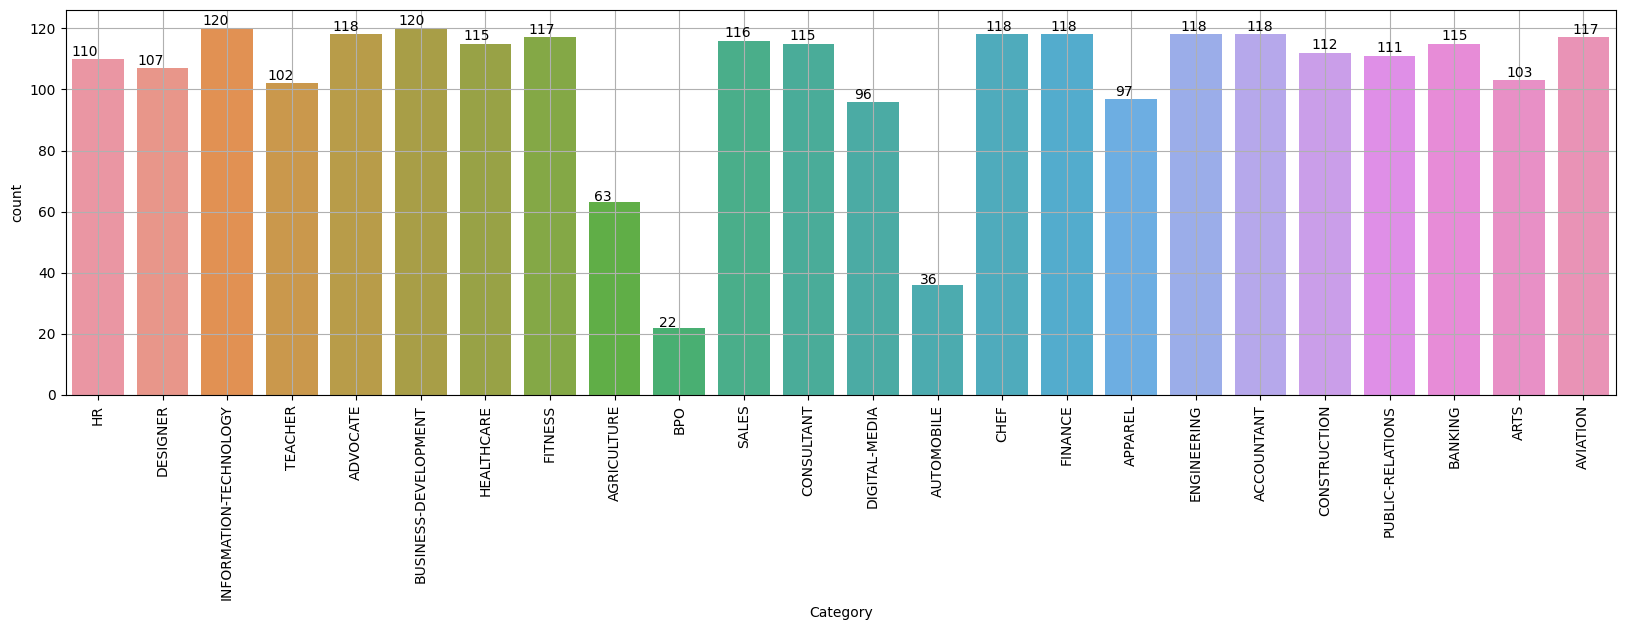

In [10]:
# showing the distribution of the categories
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
ax = sns.countplot(x="Category", data=df)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() * 1.01, p.get_height() * 1.01))

plt.grid()
plt.show()

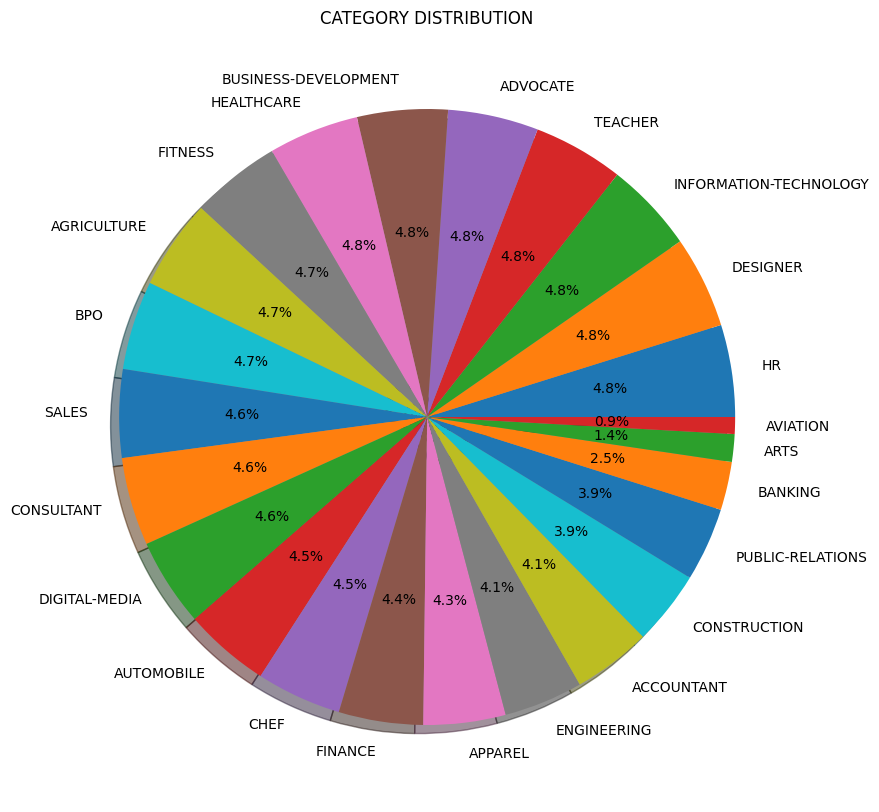

In [11]:
from matplotlib.gridspec import GridSpec
targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(22,22))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)
plt.show()

#### Preprocessing

In [12]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('\d+', '', resumeText)  # remove digits
    resumeText = re.sub('[^a-zA-Z\s]', '', resumeText)  # remove special characters (excluding whitespace and letters)
    resumeText = re.sub('@\S+', ' ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]', r' ', resumeText)  # remove non-ascii characters
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = resumeText.lower()  # convert to lowercase
    # remove stopwords from resume text
    resumeText = ' '.join(word for word in resumeText.split() if word not in stop_words)
    return resumeText
    
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))
df.head()

,Category,Resume,cleaned_resume
0,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administratormarketing associate hr adminis...
1,HR,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versati...
2,HR,HR DIRECTOR Summary Over 2...,hr director summary years experience recruitin...
3,HR,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated driven dynamic...
4,HR,HR MANAGER Skill Highlights ...,hr manager skill highlights hr skills hr depar...


In [13]:
df['cleaned_resume'][0]

'hr administratormarketing associate hr administrator summary dedicated customer service manager years experience hospitality customer service management respected builder leader customerfocused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multitasker client relations specialist omplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification omplished trainer cross server hospitality systems hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses seminars customer service sales strategies inventory control loss prevention safety time management leadership performance assessment experience hr administratormarketing associate hr administrator dec current company name city state helps develop policie

#### Most common words from Resume

In [14]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['cleaned_resume'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = cleanResume(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(10)
print(mostcommon)

[('state', 16063), ('city', 15045), ('company', 14663), ('management', 11996), ('name', 11737), ('sales', 8124), ('skills', 7695), ('business', 7686), ('customer', 7607), ('new', 6336)]


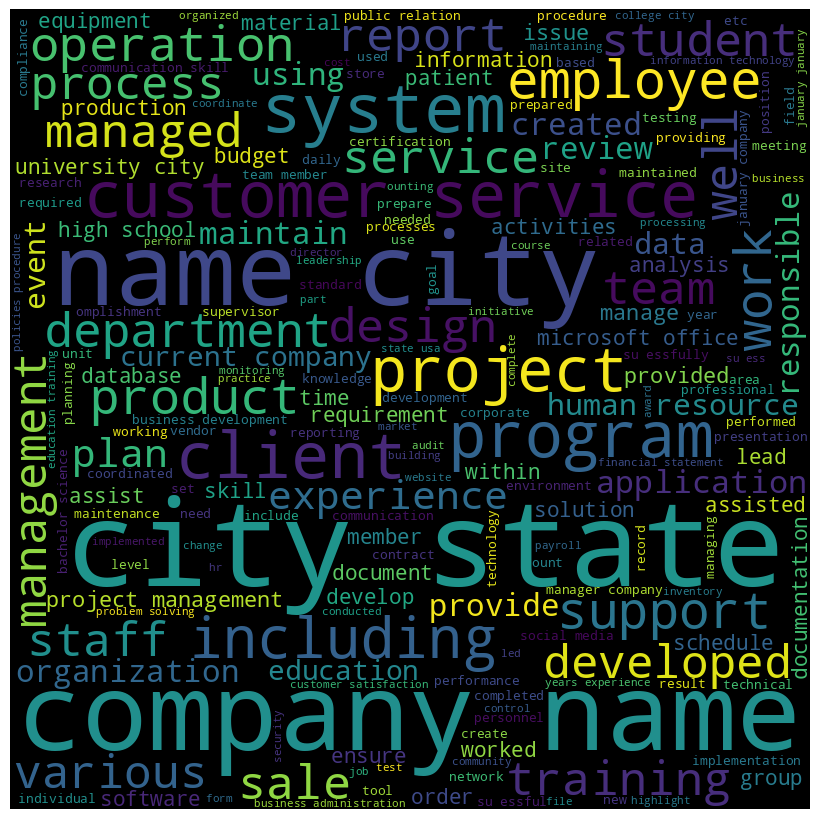

In [15]:
# Define a function to plot word cloud
from wordcloud import WordCloud, STOPWORDS
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width=800, height=800, 
                                   background_color='black', 
                                   stopwords=None,
                                   min_font_size=10).generate(text) 
             
    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad=0) 
    plt.show()

text = " ".join(i for i in df.cleaned_resume)
    
plot_word_cloud(text)

#### Encoding Target Variable

In [16]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

# Reversed dictionary
reversed_label_dict = {v: k for k, v in labels_dict.items()}
# save the labels dictionary to json file
with open('model/labels_dict.json', 'w') as fp:
    json.dump(reversed_label_dict, fp)

labels_dict

{'HR': 0,
 'DESIGNER': 1,
 'INFORMATION-TECHNOLOGY': 2,
 'TEACHER': 3,
 'ADVOCATE': 4,
 'BUSINESS-DEVELOPMENT': 5,
 'HEALTHCARE': 6,
 'FITNESS': 7,
 'AGRICULTURE': 8,
 'BPO': 9,
 'SALES': 10,
 'CONSULTANT': 11,
 'DIGITAL-MEDIA': 12,
 'AUTOMOBILE': 13,
 'CHEF': 14,
 'FINANCE': 15,
 'APPAREL': 16,
 'ENGINEERING': 17,
 'ACCOUNTANT': 18,
 'CONSTRUCTION': 19,
 'PUBLIC-RELATIONS': 20,
 'BANKING': 21,
 'ARTS': 22,
 'AVIATION': 23}

In [17]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

In [18]:
df.Category.value_counts() # understaning the label encoder

Category
2     120
5     120
15    118
4     118
18    118
17    118
14    118
23    117
7     117
10    116
21    115
6     115
11    115
19    112
20    111
0     110
1     107
22    103
3     102
16     97
12     96
8      63
13     36
9      22
Name: count, dtype: int64

In [19]:
df

,Category,Resume,cleaned_resume
0,0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administratormarketing associate hr adminis...
1,0,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versati...
2,0,HR DIRECTOR Summary Over 2...,hr director summary years experience recruitin...
3,0,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated driven dynamic...
4,0,HR MANAGER Skill Highlights ...,hr manager skill highlights hr skills hr depar...
...,...,...,...
2479,23,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,rank sgte non commissioned officer charge brig...
2480,23,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",government relations communications organizati...
2481,23,GEEK SQUAD AGENT Professional...,geek squad agent professional profile support ...
2482,23,PROGRAM DIRECTOR / OFFICE MANAGER ...,program director office manager summary highly...


### Building model

In [20]:
cleaned_resumes = df['cleaned_resume'].values
categories = df['Category'].values

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english', max_features = 3000)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_resumes)

print("Feature extraction completed ...")

Feature extraction completed ...


In [21]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(tfidf_matrix, categories, random_state=1, test_size=0.2, shuffle=True, stratify=categories)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=1, test_size=0.5, shuffle=True, stratify=y_temp)

# Print the shapes of the sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1987, 3000)
Validation set shape: (248, 3000)
Test set shape: (249, 3000)


In [22]:
# Create a Multinomial Naive Bayes classifier
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

prediction_val = mnb_model.predict(X_val)

print("Multinomial Naive Bayes")
print("Training accuracy: {:.2f} ".format(mnb_model.score(X_train, y_train)))
print("Validation accuracy: {:.2f} ".format(mnb_model.score(X_val, y_val)))
print("Classification report: \n", classification_report(y_val, prediction_val))

Multinomial Naive Bayes
Training accuracy: 0.67 
Validation accuracy: 0.52 
Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.80      0.40      0.53        10
           2       0.55      1.00      0.71        12
           3       0.44      0.70      0.54        10
           4       0.43      0.50      0.46        12
           5       0.35      0.67      0.46        12
           6       0.33      0.36      0.35        11
           7       0.67      0.50      0.57        12
           8       1.00      0.14      0.25         7
           9       0.00      0.00      0.00         2
          10       0.29      0.55      0.37        11
          11       1.00      0.09      0.17        11
          12       1.00      0.40      0.57        10
          13       0.00      0.00      0.00         4
          14       0.64      0.58      0.61        12
          15       0.55      0.50 

In [23]:
# Create a k-Nearest Neighbors (KNN) classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict on the validation data
prediction_val_knn = knn_model.predict(X_val)

# Print training and validation accuracy, and classification report for KNN
print("k-Nearest Neighbors (KNN):")
print("Training accuracy: {:.2f}".format(knn_model.score(X_train, y_train)))
print("Validation accuracy: {:.2f}".format(knn_model.score(X_val, y_val)))
print("Classification Report for KNN:")
print(classification_report(y_val, prediction_val_knn))

k-Nearest Neighbors (KNN):
Training accuracy: 0.66
Validation accuracy: 0.50
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        11
           1       0.54      0.70      0.61        10
           2       0.38      0.67      0.48        12
           3       0.54      0.70      0.61        10
           4       0.30      0.50      0.37        12
           5       0.29      0.67      0.40        12
           6       0.25      0.27      0.26        11
           7       0.75      0.50      0.60        12
           8       0.75      0.43      0.55         7
           9       0.00      0.00      0.00         2
          10       0.11      0.09      0.10        11
          11       0.50      0.18      0.27        11
          12       0.78      0.70      0.74        10
          13       0.50      0.25      0.33         4
          14       0.58      0.58      0.58        12
          15       0.75    

In [24]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
prediction_xgb = xgb_model.predict(X_val)

# Calculate accuracy
accuracy_train = accuracy_score(y_train, xgb_model.predict(X_train))
accuracy_test = accuracy_score(y_val, prediction_xgb)

# Print accuracy
print("XGBoost Classifier")
print('Training Accuracy: {:.2f}'.format(accuracy_train))
print('Validation Accuracy: {:.2f}'.format(accuracy_test))
print("Classification Report")
print(classification_report(y_val, prediction_xgb))

XGBoost Classifier
Training Accuracy: 1.00
Validation Accuracy: 0.75
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.83      1.00      0.91        10
           2       0.71      0.83      0.77        12
           3       0.78      0.70      0.74        10
           4       0.67      0.83      0.74        12
           5       0.73      0.67      0.70        12
           6       0.78      0.64      0.70        11
           7       0.73      0.67      0.70        12
           8       0.80      0.57      0.67         7
           9       0.00      0.00      0.00         2
          10       0.75      0.82      0.78        11
          11       0.67      0.73      0.70        11
          12       0.55      0.60      0.57        10
          13       0.50      0.25      0.33         4
          14       0.89      0.67      0.76        12
          15       0.91      0.83      0.87 

### Choosing the best model

In [25]:
model_filename = "model/xgbmodel.pkl"
vectorizer_filename = "model/vectorizer.pkl"
# save the xgbmodel to  and vectorizer
pickle.dump(xgb_model, open(model_filename, "wb"))
pickle.dump(tfidf_vectorizer, open(vectorizer_filename, "wb"))

print("Trained model and vectorizer saved.")

Trained model and vectorizer saved.


In [26]:
# load the model and predict the category of the resume
# Load the trained model and vectorizer using pickle
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open(vectorizer_filename, 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)


In [31]:
# Prepare a new resume for prediction
new_resume = df['cleaned_resume'][500]
# Preprocess and transform the new resume using the loaded vectorizer
new_resume_tfidf = loaded_vectorizer.transform([new_resume])

# Predict using the loaded model
prediction = loaded_model.predict(new_resume_tfidf)

with open("model/labels_dict.json", "r") as f:
    labels_dict = json.load(f)

predicted_label = prediction[0]
print("Predicted label:", predicted_label)
if str(predicted_label) in labels_dict:
    predicted_category = labels_dict[str(predicted_label)]
    print("Predicted category:", predicted_category)
else:
    print("Category not found")

4
Predicted label: 4
Predicted category: ADVOCATE
